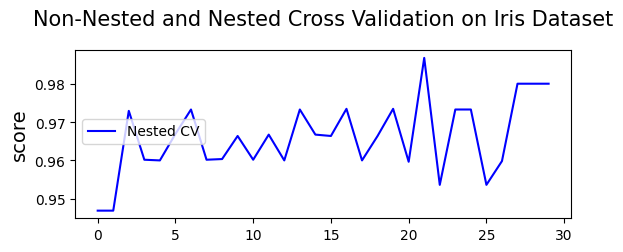

In [2]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris, load_breast_cancer
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_score, KFold
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score, precision_score, fbeta_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Number of random trials
NUM_TRIALS = 30

# Load the dataset
X_iris, y_iris = load_iris(return_X_y=True)

# Set up possible values of parameters to optimize over
p_grid = {"C": [1, 10, 100], "gamma": [0.01, 0.1]}

# We will use a Support Vector Classifier with "rbf" kernel
svm = SVC(kernel="rbf")

# Arrays to store scores
nested_scores = np.zeros(NUM_TRIALS)

# Loop for each trial
for i in range(NUM_TRIALS):
    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "GroupKFold", "LeaveOneOut", "LeaveOneGroupOut", etc.
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)

    # Nested CV with parameter optimization
    clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=inner_cv)
    nested_score = cross_val_score(clf, X=X_iris, y=y_iris, cv=outer_cv)
    nested_scores[i] = nested_score.mean()


# Plot scores on each trial for nested and non-nested CV
plt.figure()
plt.subplot(211)
(nested_line,) = plt.plot(nested_scores, color="b")
plt.ylabel("score", fontsize="14")
plt.legend(
    ["Nested CV"],
    bbox_to_anchor=(0, 0.4, 0.5, 0),
)
plt.title(
    "Non-Nested and Nested Cross Validation on Iris Dataset",
    x=0.5,
    y=1.1,
    fontsize="15",
)

plt.show()

In [51]:
import pandas as pd
from tqdm import tqdm

X, y = load_breast_cancer(return_X_y=True)

# pipeline and hyperparameter grid
pipe = make_pipeline(StandardScaler(), SVC(kernel="rbf"))
parameter_grid = {
    "svc__C": [1, 10, 100],
    "svc__gamma": [0.01, 0.1]
}

nested_model_results = []

# Inner loop: grid search for hyperparameter tuning
# perform KFold cross-val, split into 3s
inner_cv = KFold(n_splits=3, shuffle=True, random_state=1)
# splitting which cross-validator to use
grid_search = GridSearchCV(pipe, parameter_grid, cv=inner_cv, verbose=5, n_jobs=-1)


# Outer Loop: cross_val_score to eval generalization performance
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
# uses our inner grid_search as the model... oh, okay, I understand that.
nested_model_results.append(cross_validate(
    grid_search,
    X, # type: ignore
    y,
    cv=outer_cv,
    scoring={
        "fbeta": make_scorer(fbeta_score, beta=0.5),
        "accuracy": make_scorer(accuracy_score),
        "precision": make_scorer(precision_score),
        "roc_auc": make_scorer(roc_auc_score)
        },
    return_estimator=True,
    verbose=5,
    n_jobs=-1
    )
)

results_df = pd.DataFrame()

for result in nested_model_results:
    if results_df.shape[0] != 0:
        results_df = pd.concat([results_df, pd.DataFrame(result)])
    else:
        results_df = pd.DataFrame(result)


results_df['hyperparameters'] = [est.best_params_ for est in results_df['estimator']]

# we get back one score per OUTER LOOP, because the inner loop scores are performed with GridSearchCV
# for result in nested_model_results:
    # print(f"Fit Time: {score['fit_time']} --> {np.mean(score['fit_time']):.2f}s +/- {np.std(score['fit_time']):.3f}s")
    # print(f"Score Time: {score['score_time']} --> {np.mean(score['score_time']):.2f}s +/- {np.std(score['score_time']):.3f}s")
    # print(f"F-beta(0.5): {score['test_fbeta']} --> {np.mean(score['test_fbeta']):.2f} +/- {np.std(score['test_fbeta']):.3f}")
    # print(f"Accuracy: {score['test_accuracy']} --> {np.mean(score['test_accuracy']):.2f} +/- {np.std(score['test_accuracy']):.3f}")
    # print(f"Precision: {score['test_precision']} --> {np.mean(score['test_precision']):.2f} +/- {np.std(score['test_precision']):.3f}")
    # print(f"ROC_AOC: {score['test_roc_auc']} --> {np.mean(score['test_roc_auc']):.2f} +/- {np.std(score['test_roc_auc']):.3f}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   14.9s remaining:   22.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.9s finished


In [52]:
results_df

,fit_time,score_time,estimator,test_fbeta,test_accuracy,test_precision,test_roc_auc,hyperparameters
0,0.099482,0.009231,"GridSearchCV(cv=KFold(n_splits=3, random_state...",0.977961,0.982456,0.972603,0.976744,"{'svc__C': 10, 'svc__gamma': 0.01}"
1,0.097414,0.010771,"GridSearchCV(cv=KFold(n_splits=3, random_state...",0.997375,0.991228,1.000000,0.993506,"{'svc__C': 10, 'svc__gamma': 0.01}"
2,0.103382,0.006388,"GridSearchCV(cv=KFold(n_splits=3, random_state...",0.967302,0.973684,0.959459,0.965116,"{'svc__C': 10, 'svc__gamma': 0.01}"
3,0.096261,0.011299,"GridSearchCV(cv=KFold(n_splits=3, random_state...",0.977961,0.982456,0.972603,0.976744,"{'svc__C': 10, 'svc__gamma': 0.01}"
4,0.100935,0.007777,"GridSearchCV(cv=KFold(n_splits=3, random_state...",0.954416,0.964602,0.943662,0.956522,"{'svc__C': 10, 'svc__gamma': 0.01}"
